# Determining the Ice thickness of Vatnajokull based on H/V spectral ratio

## Importing modules

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
import os, sys
modules = os.path.abspath('Modules//')
if modules not in sys.path:
    sys.path.append(modules)

In [3]:
from normalize import normalize

## Functions

In [4]:
def distance_station(stt) :
    DIST_orign = [0]
    for i in range(1,len(stt)) :
        diff_X = float(stt[i][1]) - float(stt[i-1][1])
        diff_Y = float(stt[i][2]) - float(stt[i-1][2])
        dist = (diff_X**2+diff_Y**2)**(1/2)
        DIST_orign.append((DIST_orign[i-1]*1000+dist)/1000)
    return DIST_orign

In [5]:
root = "D:\MEMOIRE\Ice_thickness"
alt_glacier = '\point_altitude_glacier\point_altitude_glacier.csv'
station = "\lt_nodes_ablation_lambert.csv"
hvsr_fold = "D:\MEMOIRE\Geopsy_res\DATE_7_12"

In [6]:
with open(root+alt_glacier) as file :
    glac_alt = []
    pos = []
    line = 0
    readcsv = csv.reader(file, delimiter=',')
    for row in readcsv :
        if line > 0 :
            glac_alt.append(float(row[-1]))
            pos.append(float(row[3])/1000)
        line += 1
print(len(pos))
print(len(glac_alt))

1430
1430


In [7]:
filepath = root+station
print(filepath)
with open(filepath) as file :
    stt = []
    readcsv = csv.reader(file, delimiter=',')
    i = 0
    line = 0
    for row in readcsv :
        if line > 0 :
            stt.append([row[1]])
            stt[i].extend(row[4:7])
            i += 1
        line += 1
        
def sortThird(val):
    return val[2]
stt.sort(key=sortThird)

node_alt = []
name_station = []
for line in stt :
    node_alt.append(float(line[3]))
    name_station.append(line[0])

print(len(node_alt))

D:\MEMOIRE\Ice_thickness\lt_nodes_ablation_lambert.csv
6


In [8]:
DIST = distance_station(stt)
print(len(DIST))
#print(DIST)

6


In [9]:
stt

[['20773', '1756930.67057778', '1205501.31065622', '852'],
 ['20781', '1757497.77467811', '1211646.50005961', '1010'],
 ['20769', '1757998.30222875', '1219120.85828483', '1159'],
 ['20774', '1763952.64283821', '1223207.58530924', '1294'],
 ['20739', '1769274.68255682', '1227414.53980666', '1445'],
 ['20754', '1772111.64287197', '1232383.33887074', '1505']]

In [10]:
print(name_station)

['20773', '20781', '20769', '20774', '20739', '20754']


###### La oldest ice : Qu'est-ce que c'est ? partir sur où on la trouve, comment on la trouve et quel est l'intéret.

In [11]:
F0 = []
vs = 1900
H = []

YERRORHIGH = []
YERRORLOW = []
YERROR = []

FREQ = []
AMP_AVE = []

for nme_stt in name_station :   
    filepath = hvsr_fold+'\SS_'+ nme_stt +'.hv'
    print(filepath)
    line = 0
    with open(filepath) as file :
        tmpFREQ = []
        tmpAMP_AVE = []
        readcsv = csv.reader(file, delimiter='\t')
        for row in readcsv :
            line += 1
            if line == 5 :
                #print(row)
                f0 = float(row[1]) #extracting the f0 in the hv file
                #print(row[2])
                F0.append(f0)
                h = vs/(4.0*f0) #calculation of ice thickness
                H.append(h) #save ice thickness in a list
                yhigh = vs/(4.0*(float(row[3]))) #calculate the standart deviation of f0
                ylow = vs/(4.0*(float(row[2])))
                YERRORHIGH.append(h-yhigh)
                YERRORLOW.append(ylow-h)
            if line >= 10 and float(row[0]) >= 0.5  :
                tmpFREQ.append(float(row[0]))
                tmpAMP_AVE.append(float(row[1]))
    FREQ.append(np.array(tmpFREQ))
    AMP_AVE.append(np.array(tmpAMP_AVE))

FREQ = np.array(FREQ, dtype=object)
AMP_AVE = np.array(AMP_AVE, dtype=object)

BED_ALT = np.subtract(node_alt, H)
XERROR = ((vs/4)*np.power(F0, -1))/1000 #Lambda/4 where lambda = Vs/f0
#YERRORHIGH = 10*np.array(YERRORHIGH)
YERROR.append(YERRORLOW)
YERROR.append(YERRORHIGH)
#print(F0)
#print(H)
#print(BED_ALT)
#print(XERROR)
#print(YERROR)

D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20773.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20781.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20769.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20774.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20739.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20754.hv


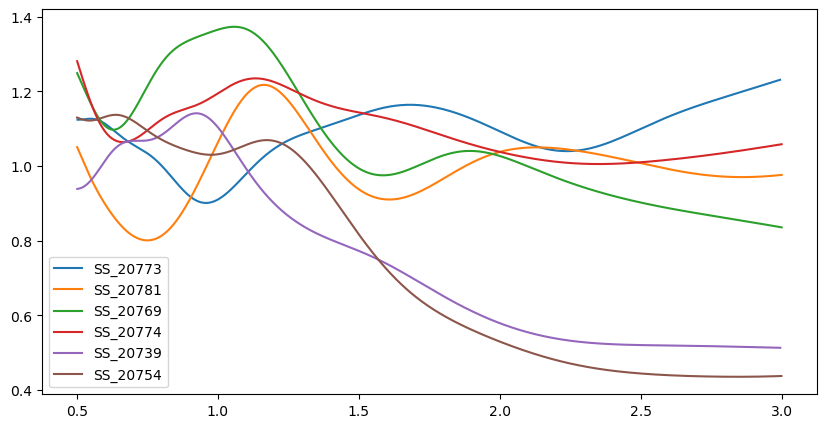

In [12]:
fig = plt.figure(figsize=(10,5))
for i in range(len(FREQ)) :
    plt.plot(FREQ[i], AMP_AVE[i], label='SS_'+str(name_station[i]))
plt.legend()
plt.savefig('plot_ice_thick/HVCurve.png')
plt.show()

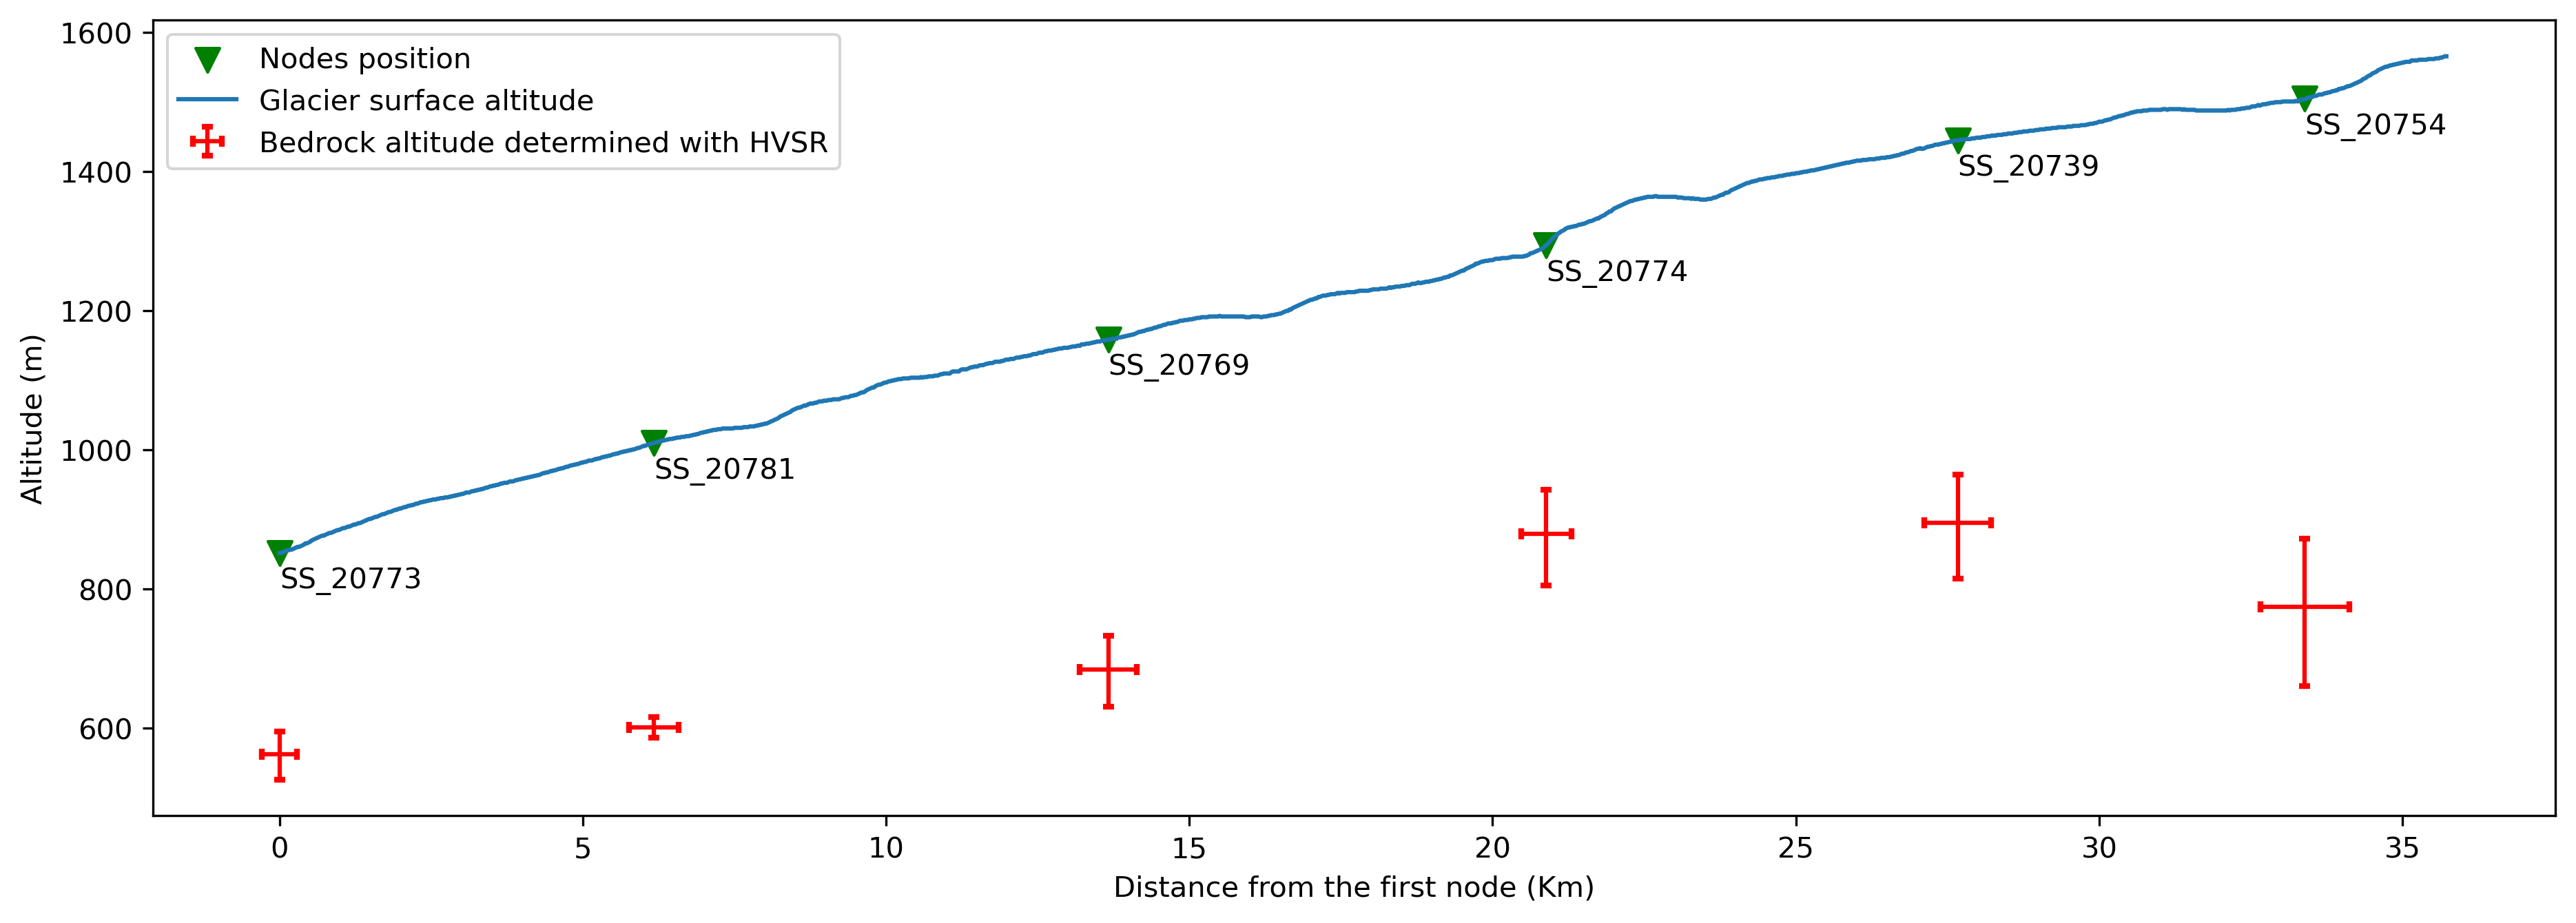

In [13]:
plt.figure(figsize=(15, 5), dpi=300)
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
#plt.scatter(DIST, BED_ALT, s=60, c='red',marker='o')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.savefig('plot_ice_thick/ice_thickness.png')
plt.show()

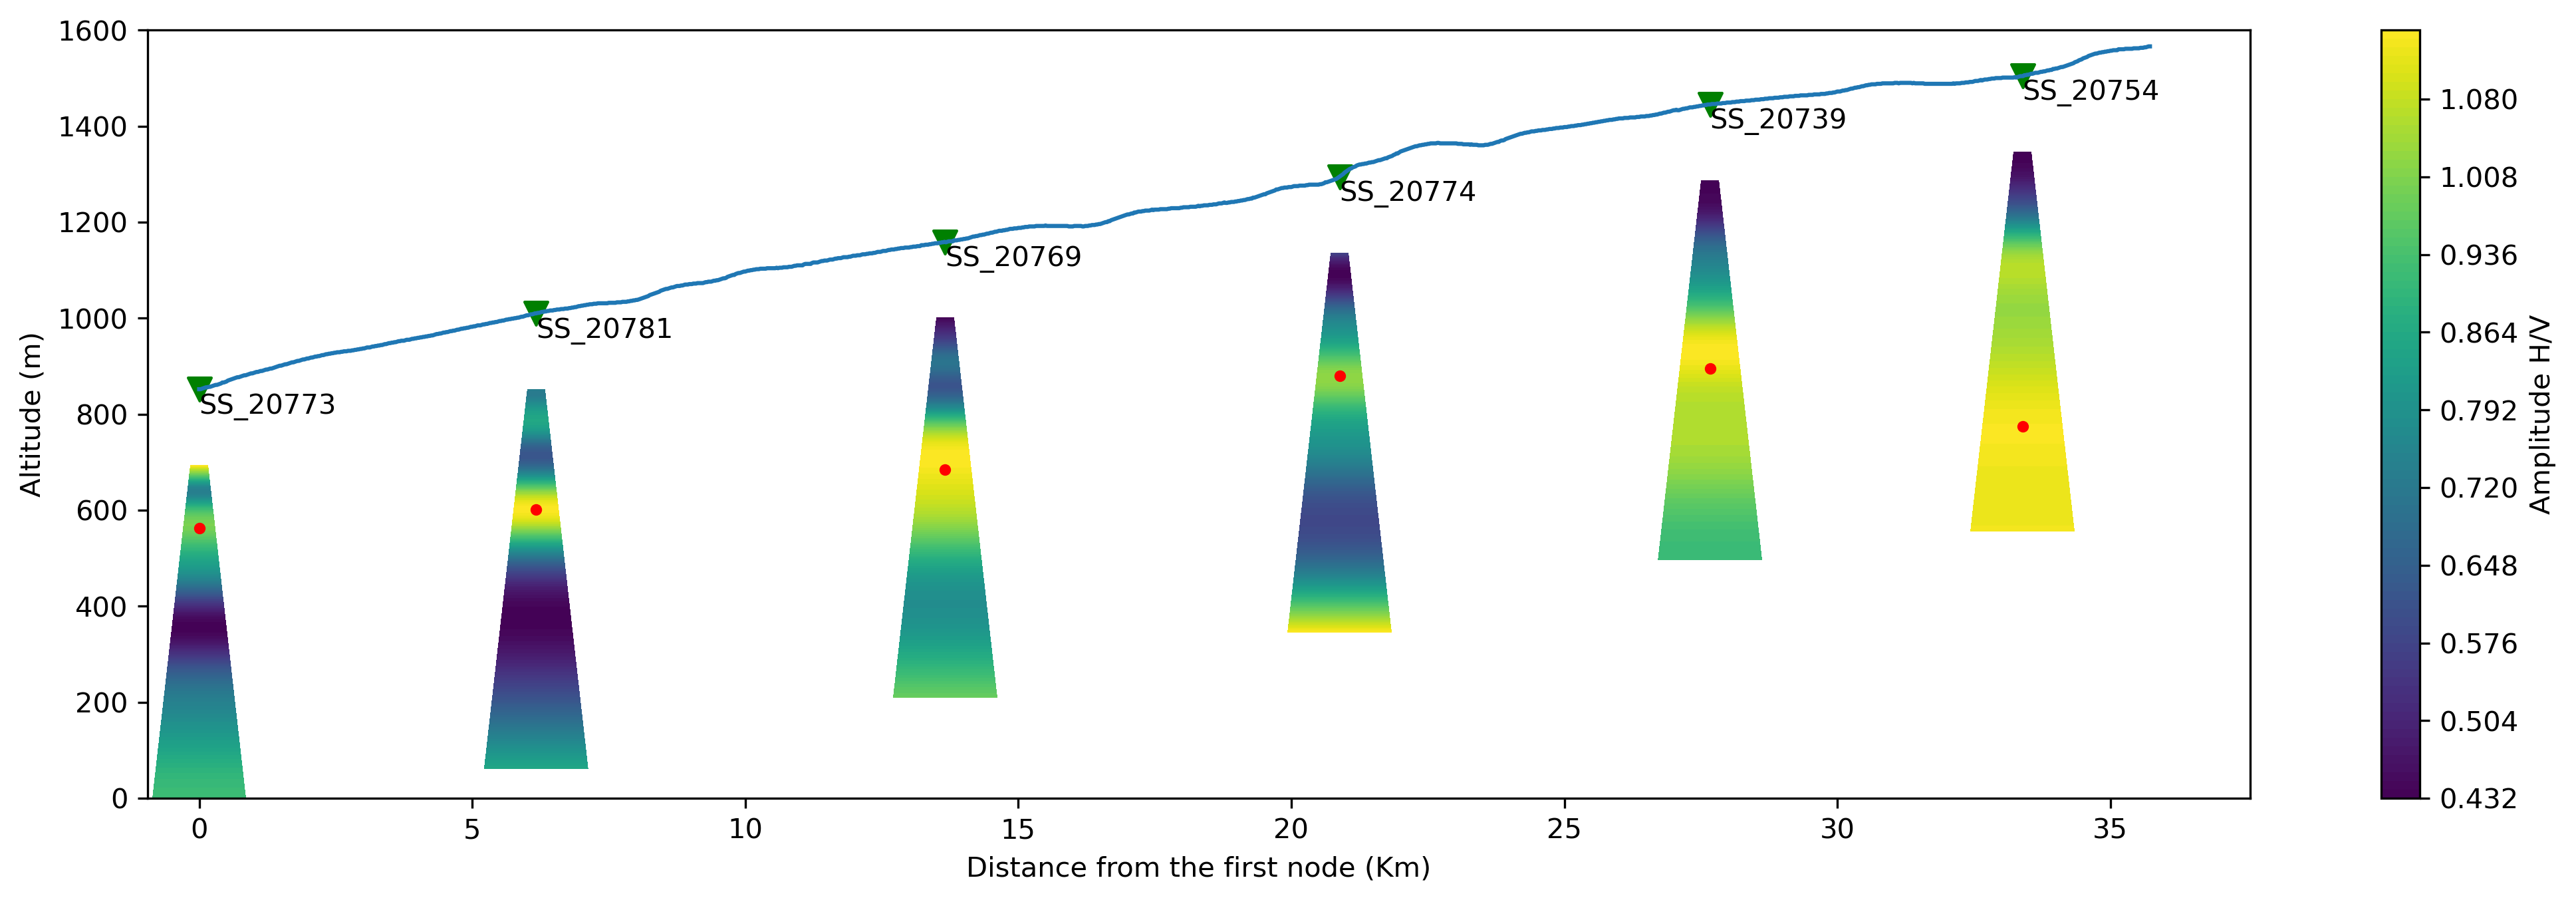

In [14]:
plt.figure(figsize=(17, 5), dpi=300)

for i in range(len(FREQ)) :
    L0 = [DIST[i]]*len(FREQ[i])
    L01 = L0 - ((vs/4)*np.power(FREQ[i], -1))/1000
    L1 = L0 + ((vs/4)*np.power(FREQ[i], -1))/1000
    L = []
    L.append(L01)
    L.append(L0)
    L.append(L1)
    L = np.array(L)
    
    HTOT = 1900/(4*np.array(FREQ[i]))
    HTOT = node_alt[i] - HTOT
    
    testFREQ = []
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ = np.array(testFREQ)

    testAMP = []
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP = np.array(testAMP)
    plt.ylim(0,1600)
    plt.contourf(L, testFREQ, testAMP, 100)
   
plt.colorbar(label = "Amplitude H/V")
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.scatter(DIST, BED_ALT, s=10, c='red',marker='o')
#plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.savefig('plot_ice_thick/HVintensity_ice_thickness.png')
plt.show()


# Automated continuous HVSR computing with hvsrpy module

Credit : https://github.com/jpvantassel/hvsrpy/blob/main/examples/simple_hvsrpy_interface.ipynb

## Importing modules and libraries

In [15]:
import hvsrpy
import obspy
import time
import datetime
import sigpropy

## Functions

In [16]:
def hvsr_export(filename, fields, ROW) :
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(fields) 

        # writing the data rows 
        csvwriter.writerows(ROW)

In [17]:
def hv_maximum(sensor, windowlenght, f_min, f_max) :
    
    #Rejection part
    n = 2 #standart deviation
    max_iterations = 50 #maximum interations to reject
    # Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
    distribution_f0 = "lognormal"
    
    
    
    startprocess = time.process_time() 
    
    distribution_mc = "lognormal"
    
    width = 0.1 #Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    bandwidth = 20 # Konno and Ohmachi smoothing constant


    # Boolean to control whether Butterworth filter is applied. 
    # Geopsy does not apply a bandpass filter.
    filter_bool = False        
    # Low-cut frequency for bandpass filter.
    filter_flow = 0.1                   
    # High-cut frequency for bandpass filter.
    filter_fhigh = 30                   
    # Filter order.
    filter_order = 5
    bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}

    # Minimum frequency after resampling
    resample_fmin = f_min  
    # Maximum frequency after resampling
    resample_fmax = f_max
    # Number of frequencies after resampling
    resample_fnum = 200
    # Type of resampling {'log', 'linear'}
    resample_type = 'log'

    resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}

    # Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
    peak_f_lower = f_min
    peak_f_upper = f_max
    # Geopsy's default is "squared-average" -> "geometric-mean" is recommended/// single-azimuth.
    method = 'single-azimuth' #"geometric-mean"
    # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    azimuth = 15

    hv = sensor.hv(windowlenght, bp_filter, width, bandwidth, resampling, method, 
               f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
    hv.reject_windows(n=n, max_iterations=max_iterations, distribution_f0=distribution_f0, distribution_mc=distribution_mc)

    
    #max_freq = hv.mc_peak_frq(distribution_mc)
    
    #max_amp = hv.mc_peak_amp(distribution_mc)
    
    meanamp = hv.mean_curve(distribution_mc)
    
    frq = hv.frq
    
    endprocess = time.process_time()
    print('Processing accomplished in '+str(endprocess-startprocess)+' seconds')
    
    return meanamp, frq


## Continuous HVSR

### Computation of continuous HVSR and saving in CSV file

In [31]:
windowlenght = 120 #second
f_min = 0.2
f_max = 40

startdate = '2022.05.08'

startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
startnumber = 3
days = 30 - startnumber

HVFREQALL = []
HVAMPALL = []
HVTIMEALL = []

STATION = ['453020739.'] #, "453020780."] ["453020754.", "453020769.", "453020774."] 



for namestt in STATION :

    HVFREQ = []
    HVAMP = []
    HVTIME = []
    for day in range(days) :
        
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        root = 'D:\\Nodes_ablation_zone\\All_comp_DP_\\'
        #root = 'D:\\Nodes_on_Vatna\\All_comp_DP_\\'
        
        traceE = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.E.miniseed')
        traceN = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.N.miniseed')
        traceZ = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.Z.miniseed')
        
        dt = traceZ[0].stats.delta
        
        starttrace = traceZ[0].stats.starttime
        
        timesize = 60 #minutes

        dtnbr = int(timesize*60/dt)
        
        nbr_timestep = int(24*60/timesize)
        

        print('Starting the time loop')

        for i in range(nbr_timestep) :
            
            posstart = int(i*dtnbr)
            posend = int((i+1)*dtnbr+1)
            
            SigtraceE = sigpropy.TimeSeries(traceE[0].data[posstart:posend], dt)
            SigtraceN = sigpropy.TimeSeries(traceN[0].data[posstart:posend], dt)
            SigtraceZ = sigpropy.TimeSeries(traceZ[0].data[posstart:posend], dt)

            sensor = hvsrpy.Sensor3c(SigtraceN,SigtraceE,SigtraceZ)

            starttime = starttrace+i*timesize*60
            endtime = starttime+timesize*60
            
            print([starttime, endtime])
            
            meanamp, frq = hv_maximum(sensor, windowlenght, f_min, f_max)
            
            name = str(namestt)+str(day)+'.'+str(i)+'.csv'
            
            starttime = datetime.datetime.strptime(str(starttime), '%Y-%m-%dT%H:%M:%S.000000Z')
            endtime = datetime.datetime.strptime(str(endtime), '%Y-%m-%dT%H:%M:%S.000000Z')
            
            root = 'res_continuous_HVSR\\'
            filename = root+name
            headers = ['FREQ','AMP','starttime','endtime']
            ROW = []
            for j in range(len(frq)) :
                ROW.append([frq[j],meanamp[j],starttime, endtime])
            hvsr_export(filename, headers, ROW)
            
            
    #HVFREQALL.append(HVFREQ)
    #HVAMPALL.append(HVAMP)
    #HVTIMEALL.append(HVTIME)


Starting the time loop
[UTCDateTime(2022, 5, 8, 0, 0), UTCDateTime(2022, 5, 8, 1, 0)]
Processing accomplished in 1.3125 seconds
[UTCDateTime(2022, 5, 8, 1, 0), UTCDateTime(2022, 5, 8, 2, 0)]
Processing accomplished in 1.296875 seconds
[UTCDateTime(2022, 5, 8, 2, 0), UTCDateTime(2022, 5, 8, 3, 0)]
Processing accomplished in 1.3125 seconds
[UTCDateTime(2022, 5, 8, 3, 0), UTCDateTime(2022, 5, 8, 4, 0)]
Processing accomplished in 1.296875 seconds
[UTCDateTime(2022, 5, 8, 4, 0), UTCDateTime(2022, 5, 8, 5, 0)]
Processing accomplished in 1.296875 seconds
[UTCDateTime(2022, 5, 8, 5, 0), UTCDateTime(2022, 5, 8, 6, 0)]
Processing accomplished in 1.390625 seconds
[UTCDateTime(2022, 5, 8, 6, 0), UTCDateTime(2022, 5, 8, 7, 0)]
Processing accomplished in 1.21875 seconds
[UTCDateTime(2022, 5, 8, 7, 0), UTCDateTime(2022, 5, 8, 8, 0)]
Processing accomplished in 1.171875 seconds
[UTCDateTime(2022, 5, 8, 8, 0), UTCDateTime(2022, 5, 8, 9, 0)]
Processing accomplished in 1.15625 seconds
[UTCDateTime(2022, 5

ValueError: zero-size array to reduction operation maximum which has no identity

### Plotting continuous HVSR from saved data in a CSV file

In [18]:
def hvsr_reader(filename, filepath) :
        line = 0
        tmpfrq = []
        tmpamp = []
        tmptimedep = []
        tmptimeend = []
        with open(filepath) as file :
                readcsv = csv.reader(file, delimiter=',')
                for row in readcsv :
                    if line > 0 and row != [] :
                        tmpfrq.append(float(row[0]))
                        tmpamp.append(float(row[1]))
                        tmptimedep.append(datetime.datetime.strptime(str(row[2]),'%Y-%m-%d %H:%M:%S'))
                        tmptimeend.append(datetime.datetime.strptime(str(row[3]),'%Y-%m-%d %H:%M:%S'))
                        strtimedep = str(row[2]).replace(' ', 'T').replace('-', '_').replace(':', '_')
                        strtimeend = str(row[3]).replace(' ', 'T').replace('-', '_').replace(':', '_')
                    line += 1
        return tmpfrq, tmpamp, tmptimedep, tmptimeend, strtimedep, strtimeend

Jour : 0
Jour : 1
Jour : 2
Jour : 3
Jour : 4
Jour : 5
Jour : 6
Jour : 7
Jour : 8


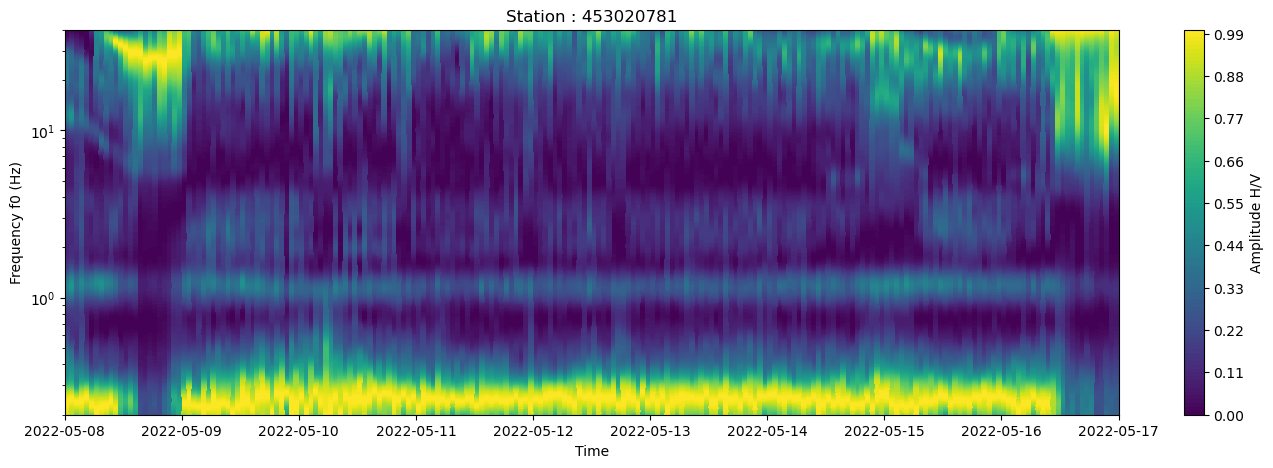

In [427]:
root = 'res_continuous_HVSR\\'
#["453020754.", "453020769.", "453020774."]
namestt = "453020781"  #"453020769" #'453020739'

fig = plt.figure(figsize=(17,5))


ContiHVTime = []
ContiHVFreq = []
ContiHVAmp = []

miniplotfrq = []
miniplotamp = []
miniplottime = []
miniplotstrtime = []
miniplottimestart = []
miniplottimestartstr = []
miniplothour = []


nbrdays = 9 #days
timestep = 60 #minutes

nbrsteps = int(24*60/timestep)

for day in range(nbrdays) :
    for i in range(nbrsteps) :
        filename = str(namestt)+'.'+str(day)+'.'+str(i)+'.csv'
        filepath = root+filename
        
        tmpfrq, tmpamp, tmptimedep, tmptimeend, strtimedep, strtimeend = hvsr_reader(filename, filepath)
        
        hour = timestep*i/60
        
        miniplotfrq.append(tmpfrq)
        miniplotamp.append(tmpamp)
        miniplottime.append([tmptimedep[0], tmptimeend[0]])
        miniplottimestart.append(tmptimedep[0])
        miniplottimestartstr.append(strtimedep)
        miniplotstrtime.append([strtimedep, strtimeend])
        
        miniplothour.append(hour) #permet de savoir si il y a une cyclicité journalière
        
        tmpamp = normalize(tmpamp)
        
        HTOT = 1900/(4*np.array(tmpfrq))
        
        ContiHVTime.append(tmptimedep)
        ContiHVTime.append(tmptimeend)
        ContiHVFreq.append(tmpfrq)
        ContiHVFreq.append(tmpfrq)
        ContiHVAmp.append(tmpamp)
        ContiHVAmp.append(tmpamp)      
        
    print('Jour : '+str(day))

ContiHVTime = np.array(ContiHVTime)
ContiHVFreq = np.array(ContiHVFreq)
ContiHVAmp = np.array(ContiHVAmp)

plt.contourf(ContiHVTime, ContiHVFreq,ContiHVAmp, 100)
plt.colorbar(label = "Amplitude H/V")
plt.title('Station : '+str(namestt) )
plt.yscale('log')
#plt.ylim(0,10)
#plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Frequency f0 (Hz)')
#plt.ylabel('Depth (m)')

plt.savefig('plot_ice_thick/continuous_HVintensity_'+str(namestt)+'.png')    

plt.show()

In [428]:
miniplotMIN = np.amin(np.array(miniplotamp), axis = 0)
miniplotMAX = np.amax(np.array(miniplotamp), axis = 0)
miniplotMEAN = np.mean(np.array(miniplotamp), axis = 0)

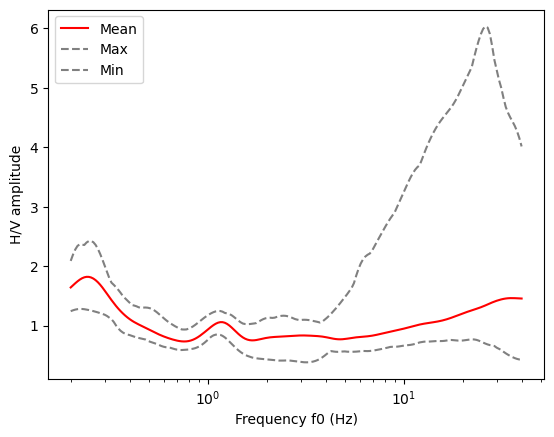

In [429]:
plt.plot(miniplotfrq[0],miniplotMEAN, c='red', label='Mean')
plt.plot(miniplotfrq[0], miniplotMIN,c='grey', linestyle='--', label='Max')
plt.plot(miniplotfrq[0], miniplotMAX,c='grey', linestyle='--', label='Min')
plt.xscale('log')
#plt.ylim(0.2,2)
plt.xlabel('Frequency f0 (Hz)')
plt.ylabel('H/V amplitude')
plt.legend()
plt.show()

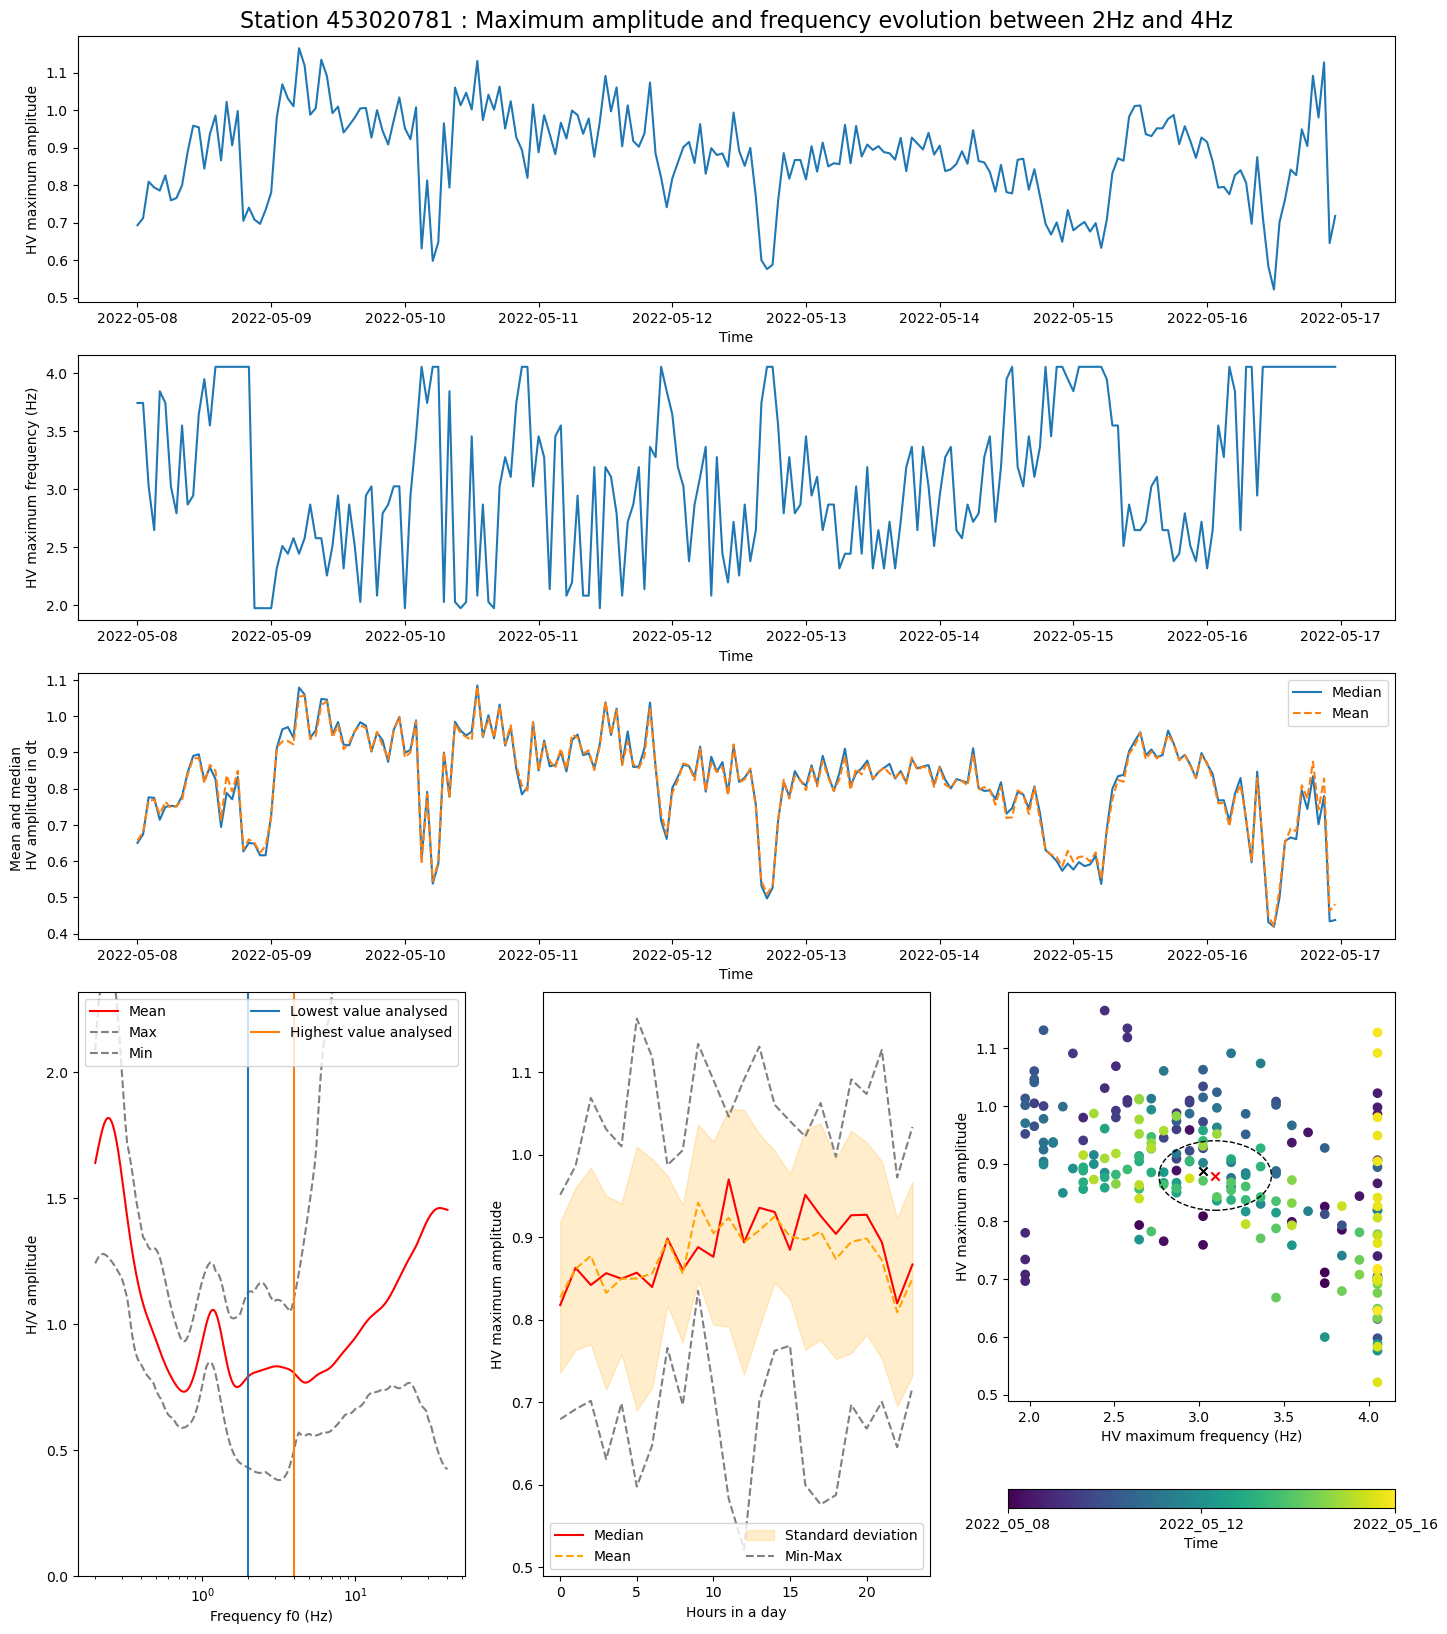

In [432]:
import numpy_indexed as npi
from matplotlib.patches import Ellipse, Circle

### DEFINE THE LOWEST FRQ AND HIGHEST FRQ TO BE ANALYSED

lowfrq = 2
highfrq = 4


# Determined the index of the lowest and highest frequency
idxlowfrq = np.argmin(np.abs(np.array(miniplotfrq[0])- lowfrq))
idxhighfrq = np.argmin(np.abs(np.array(miniplotfrq[0])- highfrq))

frqLowHigh = miniplotfrq[0][idxlowfrq:idxhighfrq+1]
AmpLowHigh = []

for elem in miniplotamp :
    AmpLowHigh.append(elem[idxlowfrq:idxhighfrq+1])
AmpLowHigh = np.array(AmpLowHigh)

maxAmpEvol = np.max(AmpLowHigh, axis = 1)
idxAmpEvol = np.argmax(AmpLowHigh, axis = 1)

maxFrqEvol = []
for idx in idxAmpEvol :
    maxFrqEvol.append(frqLowHigh[idx])
    
PosMeanMax = [np.mean(maxFrqEvol),np.mean(maxAmpEvol)]
PosMedianMax = [np.median(maxFrqEvol),np.median(maxAmpEvol)]
StdMax = [np.std(maxFrqEvol,dtype=np.float64),np.std(maxAmpEvol,dtype=np.float64)] 

col = list(range(0,len(miniplottimestart)))

maxAmp = np.max(miniplotMEAN)+.5

#### Computing the MEAN, MEDIAN AND INTEGER BETWEEN LOWEST FRQ AND HIGHEST FRQ ####

IntF = []
HOURAMPMEDIAN = []
HOURAMPMEAN = []

for day in range(nbrdays) :
    for t in range(nbrsteps):
        t += day*nbrsteps #give the array position
        HVHOUR = np.array(miniplotamp[t][idxlowfrq:idxhighfrq+1])  #Clipping the array according to lowfrq and highfrq
        FRQHOUR = np.array(miniplotfrq[t][idxlowfrq:idxhighfrq+1]) #Clipping the array according to lowfrq and highfrq
        HOURAMPMEDIAN.append(np.median(HVHOUR)) #Mediane du signal entre lowfrq et highfrq
        HOURAMPMEAN.append(np.mean(HVHOUR))     #Moyenne du signal entre lowfrq et highfrq   
        #calcule l'intégrale trapèze entre 2 points de fréquence
        tmpIntF = 0
        for AF in range(len(HVHOUR)-1) :
            tmpIntF += (HVHOUR[AF]+HVHOUR[AF+1])/(FRQHOUR[AF+1]-FRQHOUR[AF])
        IntF.append(tmpIntF)

        

#### PLOTTING THE RESULTS ####        
        
        
fig = plt.figure(figsize=(17, 20))

ax1 = plt.subplot2grid((5,3), (0,0), colspan=3)
ax1.set_ylabel('HV maximum amplitude')
ax1.set_xlabel('Time')
ax1.plot(miniplottimestart, maxAmpEvol)
ax1.set_title('Station '+str(namestt)+' : Maximum amplitude and frequency evolution between '
              +str(lowfrq)+'Hz and '+ str(highfrq)+ 'Hz', fontsize=16)

ax2 = plt.subplot2grid((5,3), (1,0), colspan=3)
ax2.set_ylabel('HV maximum frequency (Hz)')
ax2.set_xlabel('Time')
ax2.plot(miniplottimestart, maxFrqEvol)

ax2b = plt.subplot2grid((5,3), (2,0), colspan=3)
ax2b.set_ylabel('Mean and median \n HV amplitude in dt')
ax2b.set_xlabel('Time')
ax2b.plot(miniplottimestart, HOURAMPMEDIAN, label="Median")
ax2b.plot(miniplottimestart, HOURAMPMEAN,linestyle='--', label='Mean')
ax2b.legend()

ax3 = plt.subplot2grid((5,3), (3,2), colspan=1, rowspan=2)
ax3.set_ylabel('HV maximum amplitude')
ax3.set_xlabel('HV maximum frequency (Hz)')
synth = ax3.scatter(maxFrqEvol,maxAmpEvol, c=col)
ax3.scatter(PosMeanMax[0],PosMeanMax[1],c='red',marker='x')
ax3.scatter(PosMedianMax[0],PosMedianMax[1],c='black',marker='x')
ax3.add_artist(Ellipse((PosMeanMax[0],PosMeanMax[1]), StdMax[0], StdMax[1],fill=False,linestyle='--'))

cbar = fig.colorbar(synth, ax=ax3, label='Time', ticks=[np.min(col), np.max(col)/2, np.max(col)], orientation='horizontal')
cbar.ax.set_xticklabels([miniplottimestartstr[0][0:10],
                         miniplottimestartstr[int(len(col)/2)][0:10],miniplottimestartstr[len(col)-1][0:10]])
ax4 = plt.subplot2grid((5,3), (3,0), colspan=1, rowspan=2)
ax4.set_xscale('log')
ax4.plot(miniplotfrq[0],miniplotMEAN, c='red', label='Mean')
ax4.plot(miniplotfrq[0], miniplotMIN,c='grey', linestyle='--', label='Max')
ax4.plot(miniplotfrq[0], miniplotMAX,c='grey', linestyle='--', label='Min')
ax4.plot([lowfrq,lowfrq],[0,maxAmp], label = 'Lowest value analysed')
ax4.plot([highfrq,highfrq],[0,maxAmp], label = 'Highest value analysed')
ax4.set_ylim(0,maxAmp)
ax4.set_xlabel('Frequency f0 (Hz)')
ax4.set_ylabel('H/V amplitude')
ax4.legend(loc="upper left", mode="expand", ncol=2)

ax5 = plt.subplot2grid((5,3), (3,1), colspan=1, rowspan=2)
ax5.set_ylabel('HV maximum amplitude')
ax5.set_xlabel('Hours in a day')
#synth = ax5.scatter(maxFrqEvol,maxAmpEvol, c=miniplothour, cmap='seismic')
#synth5 = ax5.scatter(miniplothour,maxAmpEvol, c=maxFrqEvol, cmap='seismic')

groups, Ampmeans = npi.group_by(miniplothour).mean(maxAmpEvol)
groups, Ampmedian = npi.group_by(miniplothour).median(maxAmpEvol)
groups, Frqmeans = npi.group_by(miniplothour).mean(maxFrqEvol)
groups, Ampstds = npi.group_by(miniplothour).std(maxAmpEvol)
groups, Ampmin = npi.group_by(miniplothour).min(maxAmpEvol)
groups, Ampmax = npi.group_by(miniplothour).max(maxAmpEvol)

ax5.plot(groups, Ampmedian, c='red', label='Median')
ax5.plot(groups, Ampmeans, c='orange', linestyle = '--',label='Mean')
ax5.fill_between(groups, Ampmeans+Ampstds,Ampmeans-Ampstds,alpha=0.2,color='orange', label='Standard deviation')
#ax5.fill_between(groups, Ampmin,Ampmax,edgecolor='black', facecolor = 'None',linestyle='--', label='Min-Max')
ax5.plot(groups, Ampmin, c='grey',linestyle='--',label='Min-Max')
ax5.plot(groups, Ampmax, c='grey',linestyle='--')
#ax5.errorbar(groups,Ampmeans,yerr=Ampstds,linestyle='--',c='orange', ecolor= 'grey', capsize=2, capthick=2, label='Mean with STD')
#ax5.errorbar(groups,Frqmeans,yerr=Ampstds,linestyle='-',c='blue', ecolor= 'grey', capsize=2, capthick=2, label='STD')
ax5.legend(loc="lower left", mode="expand", ncol=2)

plt.show()

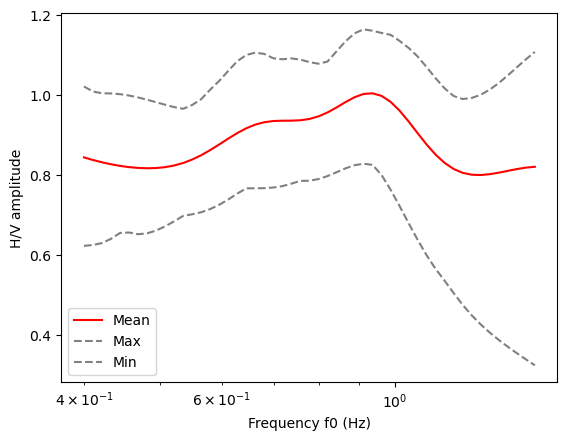

In [332]:
plt.plot(miniplotfrq[0][idxminfrq:idxmaxfrq+1],miniplotMEAN[idxminfrq:idxmaxfrq+1], c='red', label='Mean')
plt.plot(miniplotfrq[0][idxminfrq:idxmaxfrq+1], miniplotMIN[idxminfrq:idxmaxfrq+1],c='grey', linestyle='--', label='Max')
plt.plot(miniplotfrq[0][idxminfrq:idxmaxfrq+1], miniplotMAX[idxminfrq:idxmaxfrq+1],c='grey', linestyle='--', label='Min')
plt.xscale('log')
#plt.ylim(0.2,2)
plt.xlabel('Frequency f0 (Hz)')
plt.ylabel('H/V amplitude')
plt.legend()
plt.show()

### Animated HVSR plot

In [37]:
for i in range(len(miniplotfrq)) :
    plt.ioff()
    
    fig = plt.figure(figsize=(17, 5))
    ax1 = plt.subplot2grid((1,3), (0,0), colspan=2) # topleft


    ax1.contourf(ContiHVTime, ContiHVFreq,ContiHVAmp, 100)

    #ax1.set_colorbar(label = "Amplitude H/V")
    ax1.set_yscale('log')
    #ax1.set_ylim(0,10)
    #plt.gca().invert_yaxis()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency f0 (Hz)')
    #plt.ylabel('Depth (m)')

    #plt.colorbar(cont, cax=ax1, label = "Amplitude H/V")

    label = "Amplitude H/V"
    
    ax1.plot([miniplottime[i][0],miniplottime[i][0]], [0.2,40], c='red', linestyle='--')
    ax2 = plt.subplot(1, 3, 3)
    
    
    ax2.plot(miniplotamp[i], miniplotfrq[i])
    ax2.set_xlim(0,2)
    ax2.set_yscale('log')
    ax2.set_ylabel('Frequency f0 (Hz)')
    ax2.set_xlabel('Amplitude')

    fig.suptitle('Station : '+str(namestt) +' '+ str(miniplottime[i][0]) +' '+ str(miniplottime[i][1]))#, fontsize=16)

    plt.savefig('images_hvsr_gif/453020739/HVSR_'+str(namestt)+ miniplotstrtime[i][0] 
                            +'_'+miniplotstrtime[i][1]+'.png')
    print('images_hvsr_gif/453020769/HVSR_'+str(namestt)+ miniplotstrtime[i][0] 
                            +'_'+miniplotstrtime[i][1]+'.png')
    plt.close(fig)
#plt.show()

images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T00_00_00_2022_05_08T01_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T01_00_00_2022_05_08T02_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T02_00_00_2022_05_08T03_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T03_00_00_2022_05_08T04_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T04_00_00_2022_05_08T05_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T05_00_00_2022_05_08T06_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T06_00_00_2022_05_08T07_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T07_00_00_2022_05_08T08_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T08_00_00_2022_05_08T09_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T09_00_00_2022_05_08T10_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T10_00_00_2022_05_08T11_00_00.png
images_hvsr_gif/453020769/HVSR_453020739.2022_05_08T11_00_00_2022

In [39]:
import imageio.v2 as imageio
import os

files = os.listdir('.\images_hvsr_gif\\453020739\\')


path = 'C:\\Users\\julie\\Documents\\GitHub\\sismo-memo\\images_hvsr_gif\\453020739\\'
LISTIMG = []
for im in files :
    img = path+im
    LISTIMG.append(imageio.imread(img))
    
imageio.mimwrite('HVSR_453020739.gif',LISTIMG, fps=3)